In [1]:
import functools
import math
import numpy as np
from scipy import stats

import seaborn as sns
sns.set_context('notebook')
sns.set_style("white")

import matplotlib as plt
plt.rcParams['figure.figsize'] = (8,6)

from IPython.display import display

### Load Database

In [2]:
%run AH_DATABASE.ipynb


Usage: 
  db = DB(server)          --> initializes database
  db.get_df(item)          --> returns dataframe, prices divided by 100 so copper in decimal 
  db.get_name(item)        --> returns name of item  
  db.get_last_record(item) --> returns most recent record
  db.plot(item, y)         --> plots column over time



In [3]:
db = DB('earthfury-alliance', timerange=14)

In [4]:
item = 2840 # copper bar

### Percentile Functions

In [5]:
def pctBelowValue(series, value):
    return stats.percentileofscore(series, value)/100

def pctAboveValue(series, value):
    return 1-stats.percentileofscore(series, value)/100

def valueAtPctile(series, pctile):
    return series.quantile(pctile)
    

### Daily Rollups

In [6]:
def dailyMax(item, column='minBuyout'):
    # use 80 pctile instead of max() to avoid outliers
    df = db.get_df(item)
    return df.groupby(by=df['scannedAt'].dt.date)[column].quantile(.8)

def dailyMin(item, column='minBuyout'):
    # use 10 pctile instead of min() to avoid outliers
    df = db.get_df(item)
    return df.groupby(by=df['scannedAt'].dt.date)[column].quantile(.1)

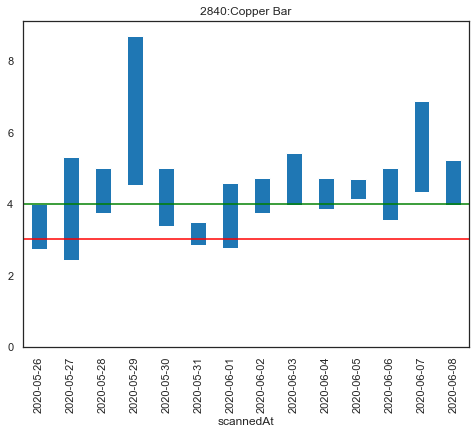

In [7]:
def plotDailyRange(item, buyAt=None, sellAt=None):
    title = f'{item}:{db.get_name(item)}'
        
    # create bars
    _, ax = plt.subplots()
    dailyMax(item).plot(kind='bar', x='scannedAt', y='minBuyout', title=title, ax=ax)
    dailyMin(item).plot(kind='bar', x='scannedAt', y='minBuyout', color='w', ax=ax)
    
    # add buy lines if passed
    if buyAt and sellAt:
        ax.axhline(y=buyAt, color='red')
        ax.axhline(y=sellAt, color='green')

    
plotDailyRange(item, 3, 4)

### Analysis

In [8]:
def postcost_at_salerate(item, salerate):
    if salerate == 0:
        return 0
    vp = db.get_vendorprice(item) # double check this value is working correctly using in game reference 
    return (1-salerate) / salerate * (.6*vp)

def iterPrice(item):
    # iterate from min price to max price in .01 percentile steps
    for pctile in np.arange(0, 1, .01):
        yield db.get_df_hourly(item)['minBuyout'].quantile(pctile)

,item_id,name,sellPrice,availSell,postCost,maxBuy,meanBuy,availBuy,value,flipRate,timeValue,roi
83,10940,Strange Dust,4.888,0.428571,0.0,4.6436,2.567519,0.806154,2.320481,0.345495,0.801713,0.312252


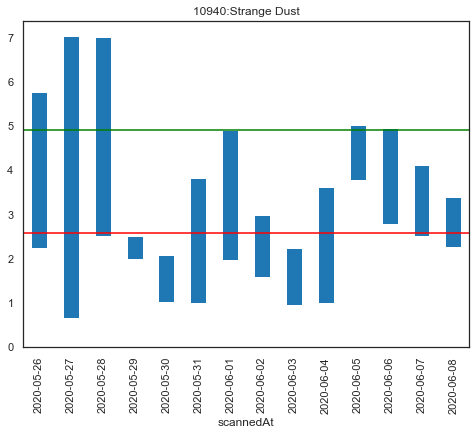

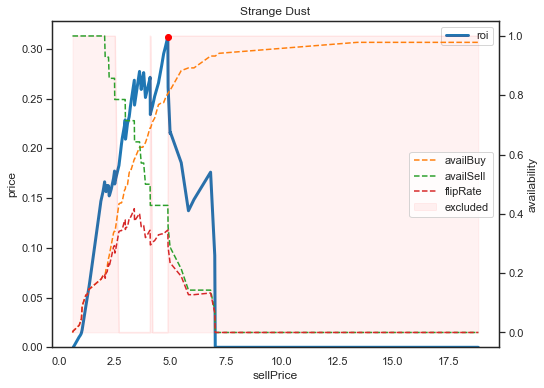

In [9]:
def analysis(item, show=False):
    columns = ['sellPrice', 'availSell', 'postCost', 'maxBuy', 'meanBuy', 'availBuy', 'value', 'timeValue', 'roi']
    data = []
    for sellPrice in iterPrice(item):
        availSell = pctAboveValue(dailyMax(item), sellPrice) # use dailyMax series due to selling pattern

        # expected posting cost based on avail sell
        postCost = postcost_at_salerate(item, availSell)

        # buying values
        maxBuy   = sellPrice * .95
        meanBuy  = db.get_df_hourly(item).query('minBuyout <= @maxBuy')['minBuyout'].mean()
        availBuy = pctBelowValue(db.get_df_hourly(item)['minBuyout'], maxBuy) # use hourly series due to buying pattern        

        # profit
        value = sellPrice - meanBuy - postCost
        timeValue = value * availSell * availBuy
        roi = timeValue / (meanBuy + postCost)        
        
        # load into data
        data.append({
            'item_id'  :item,
            'name'     :db.get_name(item),
            'sellPrice':sellPrice,
            'availSell':availSell, 
            'postCost' :postCost,
            'maxBuy'   :maxBuy, 
            'meanBuy'  :meanBuy,
            'availBuy' :availBuy,
            'value'    :value, 
            'flipRate' :availSell * availBuy,
            'timeValue':timeValue, 
            'roi'      :roi,        
        })
    
    # no data caused by 100% exclusion
    if data == []:
        print(f'{item}:{db.get_name(item)} excluded')
        return

    # data frame for analysis
    df = pd.DataFrame(data)    
    cutoff = .3 # only consider sell rates above X
    best = df.loc[df['roi'] == df.query('flipRate > @cutoff')['roi'].max()]
    if best.empty:
        # if no optimal found above cutoff, find best anyway
        best = df.loc[df['roi'] == df['roi'].max()]
    
    if show:
        # plot daily range and buy/sell lines
        display(best)
        plotDailyRange(item, best.iloc[0]['meanBuy'], best.iloc[0]['sellPrice'])
        
        # plot analysis curve
        _, ax = plt.subplots()
        df.plot(x='sellPrice', y=['roi'], title=db.get_name(item), linewidth=3, ax=ax)
        plt.plot(best['sellPrice'],best['roi'],'ro') 
        
        # create exclusion zone based on cutoff
        df['excluded'] = df['flipRate'].apply(lambda x: x<cutoff).astype(int)
        df.plot(kind='area', x='sellPrice', y='excluded', secondary_y=True, color='red', alpha=.05, ax=ax, legend=False)
        
        # plot roi and rates
        df.plot(x='sellPrice', y=['availBuy', 'availSell', 'flipRate'], style='--', secondary_y=True, ax=ax, legend=False).legend(loc='center right')
        ax.set_ylabel('price')
        ax.right_ax.set_ylabel('availability')
        return
    return best.to_dict('r')[0]
    
analysis(10940, show=True)

### Full Run

In [10]:
%run ITEMS.ipynb


loaded
  herbs       : 30 items
  cloth       : 12 items
  mining      : 27 items
  enchant     : 24 items
  skinning    : 11 items
  meat        : 27 items
  consumables : 44 items
  bags        : 38 items
  eng         : 53 items
  ALL         : 266 items
  CHOICE      : 70 items (quantity>100 and sellPrice>2.5s)



In [11]:
%%time

# a bunch of printing and error catching, to simply map(fn, list_of_items)
def run_analysis(list_of_items, fn):
    print(f'running for {len(list_of_items)} items')    
    results = []    
    for i, item in enumerate(list_of_items):       
        # catch no data errors with try/except
        try:
            results.append(fn(item))
        except: 
            print(f'! ERROR - {item}, {db.get_name(item)}')
        # print progress
        if i%10 ==0: print(f' ...{i} done')   
    print('COMPLETE')
    return pd.DataFrame(results).round(2)

df = run_analysis(ALL, analysis)

running for 266 items
 ...0 done
 ...10 done
 ...20 done
 ...30 done
 ...40 done
 ...50 done
 ...60 done
! ERROR - 17771, Elementium Bar
! ERROR - 3861, Blacksteel Bar
 ...70 done
 ...80 done
 ...90 done
! ERROR - 20725, Nexus Crystal
 ...100 done
 ...110 done
 ...120 done
! ERROR - 5467, Kodo Meat
 ...130 done
 ...140 done
! ERROR - 20748, Brilliant Mana Oil
! ERROR - 20749, Brilliant Wizard Oil
! ERROR - 21546, Elixir of Greater Firepower
 ...150 done
 ...160 done
 ...170 done
! ERROR - 21023, Dirge's Kickin' Chimaerok Chops
 ...180 done
! ERROR - 1652, Sturdy Lunchbox
 ...190 done
! ERROR - 4497, Heavy Brown Bag
 ...200 done
 ...210 done
 ...220 done
 ...230 done
 ...240 done
! ERROR - 4399, Wooden Stock
! ERROR - 4400, Heavy Stock
 ...250 done
 ...260 done
COMPLETE
Wall time: 8min 40s


### Creat Choice

In [40]:
pd.set_option('display.max_rows', None)
df['quantity'] = df['item_id'].apply(lambda x: int(db.get_df_hourly(x)['quantity'].mean()))
choice = df.query('flipRate>.2 and sellPrice>3 and quantity>100').sort_values(by='roi')
choice

,item_id,name,sellPrice,availSell,postCost,maxBuy,meanBuy,availBuy,value,flipRate,timeValue,roi,quantity
207,12804,Powerful Mojo,24.51,0.57,9.00,23.28,20.32,0.56,-4.81,0.32,-1.53,-0.05,108
32,4338,Mageweave Cloth,4.93,0.43,2.00,4.68,3.96,0.72,-1.03,0.31,-0.32,-0.05,1585
97,4304,Thick Leather,5.31,0.71,0.72,5.05,4.66,0.45,-0.06,0.32,-0.02,-0.00,595
39,4305,Bolt of Silk Cloth,11.56,0.64,2.00,10.98,9.43,0.54,0.13,0.35,0.04,0.00,102
5,8845,Ghost Mushroom,110.65,0.71,0.90,105.12,102.29,0.36,7.46,0.26,1.92,0.02,338
64,12359,Thorium Bar,19.00,0.64,2.00,18.05,15.90,0.51,1.10,0.33,0.36,0.02,902
61,3577,Gold Bar,12.08,0.86,0.60,11.48,10.78,0.37,0.70,0.32,0.22,0.02,151
130,13452,Elixir of the Mongoose,869.89,0.86,1.25,826.40,802.65,0.28,65.99,0.24,15.74,0.02,104
131,13454,Greater Arcane Elixir,413.75,0.29,11.25,393.06,361.07,0.76,41.43,0.22,8.98,0.02,109
34,14047,Runecloth,6.18,0.93,0.18,5.87,5.34,0.23,0.66,0.21,0.14,0.03,5471


In [41]:
df.loc[df['name'].str.contains('Squid')]

,item_id,name,sellPrice,availSell,postCost,maxBuy,meanBuy,availBuy,value,flipRate,timeValue,roi,quantity
162,13928,Grilled Squid,184.06,0.29,0.12,174.85,140.05,0.72,43.89,0.21,9.05,0.06,328


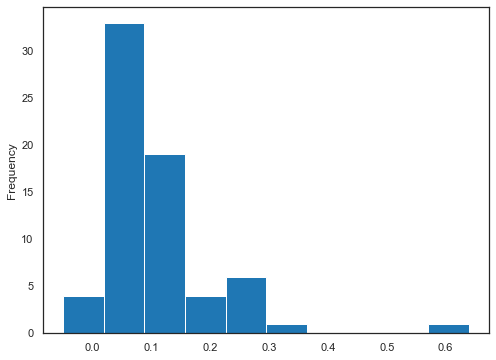

In [42]:
choice['roi'].plot(kind='hist')

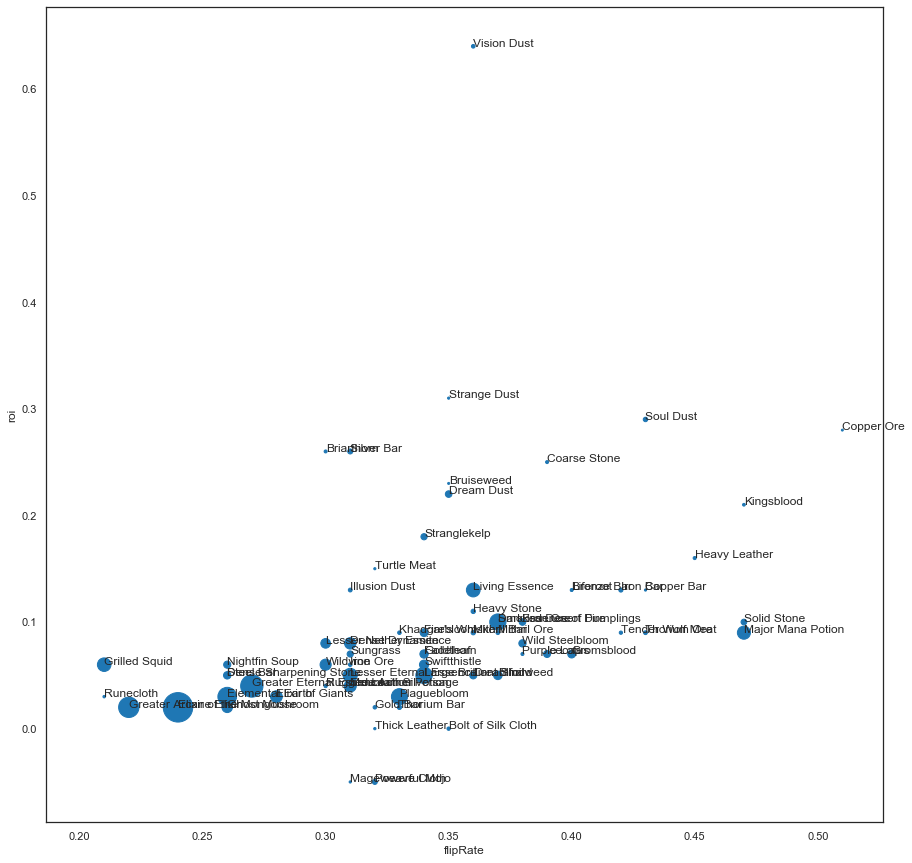

In [43]:
x = 'flipRate'
y = 'roi'
ax = choice.plot(kind='scatter', x=x, y=y, s=choice['sellPrice'], figsize=(15,15))

for _, r in choice.iterrows():
    ax.text(r[x], r[y], r['name'])    

### Inspect Results

In [44]:
t = choice.copy()
t['median'] = t['item_id'].apply(lambda x: db.get_df_hourly(x)['minBuyout'].median())
t['pctOfMedian'] = t['sellPrice'] / t['median']
t['stdNorm'] = t['item_id'].apply(lambda x: db.get_df_hourly(x)['minBuyout'].std()) / t['sellPrice']
t.sort_values(by='pctOfMedian').tail(5)

,item_id,name,sellPrice,availSell,postCost,maxBuy,meanBuy,availBuy,value,flipRate,timeValue,roi,quantity,median,pctOfMedian,stdNorm
70,11176,Dream Dust,43.66,0.43,0.00,41.48,26.65,0.81,17.01,0.35,5.88,0.22,315,27.50,1.587636,0.382252
67,10940,Strange Dust,4.89,0.43,0.00,4.64,2.57,0.81,2.32,0.35,0.80,0.31,246,2.94,1.663265,0.570097
55,2842,Silver Bar,25.71,0.36,1.08,24.42,12.77,0.86,11.86,0.31,3.64,0.26,169,13.99,1.837741,0.278127
15,2450,Briarthorn,9.07,0.36,0.27,8.62,4.64,0.85,4.17,0.30,1.26,0.26,315,4.83,1.877847,0.357847
69,11137,Vision Dust,13.22,0.43,0.00,12.56,4.73,0.83,8.50,0.36,3.04,0.64,477,4.82,2.742739,0.337933


,item_id,name,sellPrice,availSell,postCost,maxBuy,meanBuy,availBuy,value,flipRate,timeValue,roi
65,769,Chunk of Boar Meat,5.09,0.642857,0.01,4.8355,1.481305,0.620795,3.598695,0.399083,1.436176,0.963033


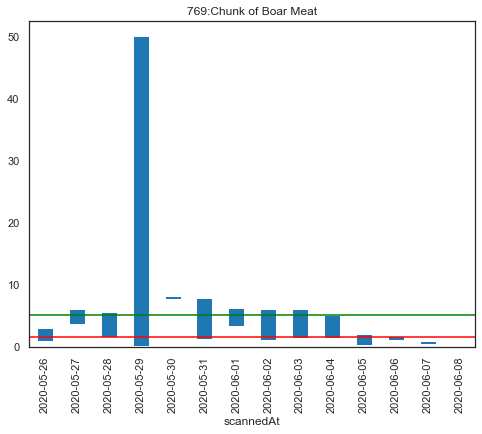

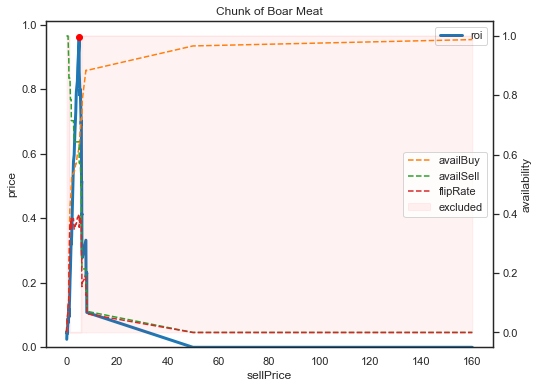

In [45]:
analysis(769, True)

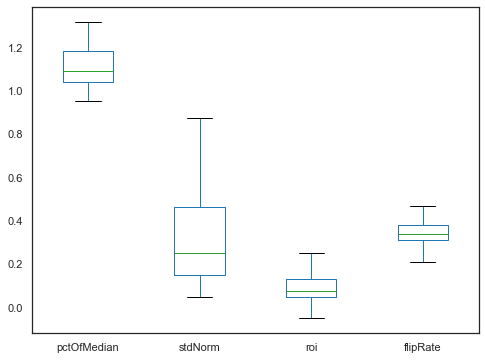

In [46]:
t.plot(kind='box', y=['pctOfMedian', 'stdNorm', 'roi', 'flipRate'], showfliers=False)

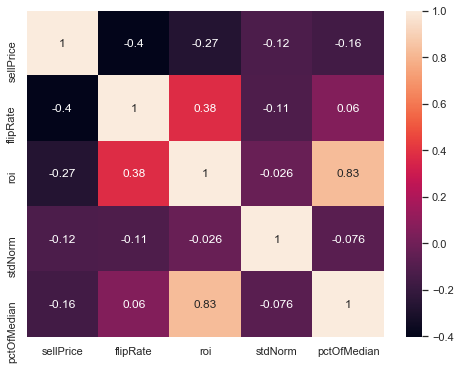

In [47]:
import seaborn as sns
tcorr = t[['sellPrice','flipRate','roi','stdNorm','pctOfMedian']].corr()
# plot the heatmap and annotation on it
sns.heatmap(tcorr, xticklabels=tcorr.columns, yticklabels=tcorr.columns, annot=True)

### Export

In [48]:
%run EXPORT.ipynb

 
Usage:
  EXPORT(dataframe) --> expects df with specific columns
                          name         - required, string
                          item_id      - required, integer
                          buy_price    - required, integer in copper
                          min_price    - required, integer in copper 
                          normal_price - required, integer in copper
                          max_price    - required, integer in copper
                          restock      - optional, default 20
  example_export_input()  --> shows expected data schema
  example_export_output() --> shows output of example data



In [49]:
e = choice.copy()
# format for export (note, 100x to scale integer copper) | e['name'] = e.apply(lambda row: f'sr{row['availRate']} roi{row['roi']} {row['name']}')

e['name'] = e.apply(lambda row: f"{int(100*row['availSell'])}sr_{int(100*row['roi'])}roi_{row['name']}", axis=1)
e['buy_price']    = 100 * e['sellPrice'] * .95 
e['min_price']    = 100 * e['sellPrice']
e['normal_price'] = 100 * e['sellPrice'] * 1.1 # bit more profit when lowest post, but don't hurt saleRate
e['max_price']    = 100 * e['sellPrice'] * 1.1 # bit more profit when lowest post, but don't hurt saleRate
e = e.astype({'buy_price':int, 'min_price':int, 'normal_price':int, 'max_price':int})
e.head()

,item_id,name,sellPrice,availSell,postCost,maxBuy,meanBuy,availBuy,value,flipRate,timeValue,roi,quantity,buy_price,min_price,normal_price,max_price
207,12804,56sr_-5roi_Powerful Mojo,24.51,0.57,9.00,23.28,20.32,0.56,-4.81,0.32,-1.53,-0.05,108,2328,2451,2696,2696
32,4338,43sr_-5roi_Mageweave Cloth,4.93,0.43,2.00,4.68,3.96,0.72,-1.03,0.31,-0.32,-0.05,1585,468,493,542,542
97,4304,71sr_0roi_Thick Leather,5.31,0.71,0.72,5.05,4.66,0.45,-0.06,0.32,-0.02,-0.00,595,504,531,584,584
39,4305,64sr_0roi_Bolt of Silk Cloth,11.56,0.64,2.00,10.98,9.43,0.54,0.13,0.35,0.04,0.00,102,1098,1156,1271,1271
5,8845,71sr_2roi_Ghost Mushroom,110.65,0.71,0.90,105.12,102.29,0.36,7.46,0.26,1.92,0.02,338,10511,11065,12171,12171


In [50]:
# restock=75 if item price is less than 1g, else stack_size=30
e['restock'] = e['sellPrice'].apply(lambda x: 75 if x < 100 else 30)

# stack_size=10 if item price is less than 1g, else stack_size=5
e['stack_size'] = e['sellPrice'].apply(lambda x: 10 if x < 100 else 5)

In [51]:
#EXPORT(e.sort_values('flipRate').tail(10))
EXPORT(e)

^1^T^Soperations^T^SMailing^T^S#Default^T^Srestock^b^SkeepQty^N0^SmaxQtyEnabled^b^Starget^S^SrestockSources^T^Sguild^b^Sbank^b^t^SmaxQty^N10^t^t^SAuctioning^T^Ss56sr_-5roi_Powerful Mojo^T^SaboveMax^SmaxPrice^SnormalPrice^S2696^Sduration^N3^SmatchStackSize^b^SkeepQuantity^N0^SpostCap^N5^SbidPercent^N1^SstackSizeIsCap^B^SmaxPrice^S2696^SignoreLowDuration^N0^SstackSize^N1^SkeepPosted^N0^Sundercut^S1c^SmaxExpires^N0^SpriceReset^SminPrice^ScancelRepostThreshold^S1g^ScancelRepost^B^ScancelUndercut^B^SminPrice^S2451^SkeepQtySources^T^t^Sblacklist^S^t^SS56sr_-5roi_Powerful Mojo^T^SaboveMax^SmaxPrice^SnormalPrice^S2696^Sduration^N3^SmatchStackSize^b^SkeepQuantity^N0^SpostCap^N20^SbidPercent^N1^SstackSizeIsCap^B^SmaxPrice^S2696^SignoreLowDuration^N0^SstackSize^N10^SkeepPosted^N0^Sundercut^S1c^SmaxExpires^N0^SpriceReset^SminPrice^ScancelRepostThreshold^S1g^ScancelRepost^B^ScancelUndercut^B^SminPrice^S2451^SkeepQtySources^T^t^Sblacklist^S^t^Ss43sr_-5roi_Mageweave Cloth^T^SaboveMax^SmaxPrice^Snorma